# V.6
- EfficientNet
- 예측이 잘 안 되는 데이터만 사용한 모델
- 데이터 불러올 때 증강 사용

In [1]:
import pandas as pd
import numpy as np
import os
import time
import random
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import timm
import torch
import albumentations as A
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from augraphy import *

from sklearn.metrics import accuracy_score, f1_score

import wandb

import warnings
warnings.filterwarnings("ignore")

In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cuda')

# CustomDataset

In [6]:
train_df = pd.read_csv('/data/ephemeral/home/data/train.csv')
train_df

,ID,target
0,002f99746285dfdd.jpg,16
1,008ccd231e1fea5d.jpg,10
2,008f5911bfda7695.jpg,10
3,009235e4c9c07af5.jpg,4
4,00b2f44967580c74.jpg,16
...,...,...
1565,fed9e9ec4a77bc06.jpg,4
1566,feeade617aa68c45.jpg,7
1567,ff51dd281a8423f1.jpg,11
1568,ff8a6a251ce51c95.jpg,5


In [8]:
train_df = train_df[(train_df['target']==0) | (train_df['target']==1) | (train_df['target']==3) |
         (train_df['target']==4) | (train_df['target']==6) | (train_df['target']==7) |
         (train_df['target']==10) | (train_df['target']==11) | (train_df['target']==12) | 
         (train_df['target']==13) | (train_df['target']==14)]

In [9]:
mapping = {0:0, 1:1, 3:2, 4:3, 6:4, 7:5, 10:6, 11:7, 12:8, 13:9, 14:10}

train_df['target'] = train_df['target'].map(mapping)
train_df

,ID,target
1,008ccd231e1fea5d.jpg,6
2,008f5911bfda7695.jpg,6
3,009235e4c9c07af5.jpg,3
9,012913977fd1d980.jpg,10
14,024fe478044874ab.jpg,9
...,...,...
1562,fe89027e179546dc.jpg,4
1563,fe9683317086dbab.jpg,2
1565,fed9e9ec4a77bc06.jpg,3
1566,feeade617aa68c45.jpg,5


In [10]:
train_df.to_csv('/data/ephemeral/home/data/train_2.csv', index=False)

In [5]:
class customdataset(torch.utils.data.Dataset):
    def __init__(self, csv, path, transforms, pipeline):
        super().__init__()
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transforms = transforms
        self.pipeline = pipeline

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        img = self.pipeline(img)
        img = self.transforms(img)
    
        return img, target

In [6]:
class RandomPadding:
    def __init__(self, padding_range=(0, 50), fill=0):
        self.padding_range = padding_range
        self.fill = fill

    def __call__(self, image):
        # 각 방향에 대해 랜덤한 패딩 값 생성
        pad_top = random.randint(*self.padding_range)
        pad_bottom = random.randint(*self.padding_range)
        pad_left = random.randint(*self.padding_range)
        pad_right = random.randint(*self.padding_range)
        
        # 패딩 추가
        padding = (pad_left, pad_top, pad_right, pad_bottom)
        return T.functional.pad(image, padding, fill=self.fill)

In [15]:
aug_transforms = T.Compose([
    T.ToTensor(),
    T.RandomRotation(180),
    T.RandomHorizontalFlip(p=0.5),
    RandomPadding(padding_range=(10, 20), fill=50),  # 랜덤 패딩 추가
    T.RandomResizedCrop(size=(550,550), scale=(0.5, 1.0)),
    T.Resize((380, 380))
])

augmentations = [
    NoiseTexturize(sigma_range=(6, 10),
                  turbulence_range=(5, 10),
                  texture_width_range=(50, 500),
                  texture_height_range=(50, 500)),
    Folding(fold_count=2,
            fold_noise=0.0,
            fold_angle_range = (-180,180),
            gradient_width=(0.01, 0.05),
            gradient_height=(0.01, 0.05),
            backdrop_color = (0,0,0)),
    BadPhotoCopy(
        noise_type=-1,
        noise_side="random",
        noise_iteration=(1, 2),
        noise_size=(1, 3),
        noise_value=(128, 196),
        noise_sparsity=(0.3, 0.6),
        noise_concentration=(0.1, 0.6),
        blur_noise=random.choice([True, False]),
        blur_noise_kernel=random.choice([(3, 3), (5, 5), (7, 7)]),
        wave_pattern=random.choice([True, False]),
        edge_effect=random.choice([True, False]),
        p=0.33,
    ),
]

pipeline = AugraphyPipeline(augmentations)

train_dataset = customdataset('/data/ephemeral/home/data/train_2.csv', '/data/ephemeral/home/data/train/', transforms=aug_transforms, pipeline=pipeline)

In [16]:
len(train_dataset)

970

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..50.0].


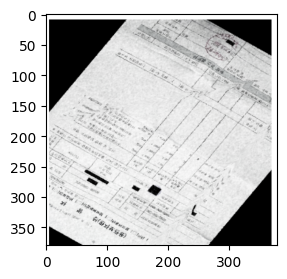

In [17]:
plt.figure(figsize=(3, 3))
plt.imshow(train_dataset[100][0].permute(1, 2, 0))
plt.show()

# valid dataset

### train data 중 일부 사용

In [18]:
total_num = len(train_dataset)
train_num, valid_num = int(total_num*0.9), int(total_num*0.1)

train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_num, valid_num])

In [19]:
print(len(train_dataset), len(valid_dataset))

873 97


### 최고점 모델 예측 사용

In [16]:
valid_df = pd.read_csv('/data/ephemeral/home/preds/minjun_best_score.csv')
valid_df = valid_df[(valid_df['target']==0) | (valid_df['target']==1) | (valid_df['target']==3) |
         (valid_df['target']==4) | (valid_df['target']==6) | (valid_df['target']==7) |
         (valid_df['target']==10) | (valid_df['target']==11) | (valid_df['target']==12) |
         (valid_df['target']==13) | (valid_df['target']==14)]
valid_df['target'] = valid_df['target'].map(mapping)
valid_df.to_csv('/data/ephemeral/home/preds/minjun_best_score_2.csv', index=False)

In [17]:
valid_df

,ID,target
1,00091bffdffd83de.jpg,8
3,00471f8038d9c4b6.jpg,8
6,00b33e0ee6d59427.jpg,0
9,00c0dabb63ca7a16.jpg,7
11,00e15da96484eb94.jpg,2
...,...,...
3133,ff70a399a80c1c96.jpg,7
3135,ffb4b6f619fb60ea.jpg,4
3136,ffb54299b1ad4159.jpg,6
3138,ffc4e330a5353a2a.jpg,0


In [18]:
valid_transforms = T.Compose([
    T.ToTensor(),
    T.Resize((380, 380))
])

pipeline = AugraphyPipeline()

valid_dataset = customdataset('/data/ephemeral/home/preds/minjun_best_score_2.csv', '/data/ephemeral/home/data/test/', transforms=valid_transforms, pipeline=pipeline) # valid dataset

In [19]:
len(valid_dataset)

1939

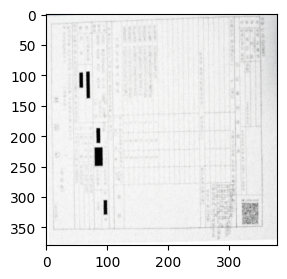

In [20]:
plt.figure(figsize=(3, 3))
plt.imshow(valid_dataset[0][0].permute(1, 2, 0))
plt.show()

In [23]:
batch_size = 16

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=16)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size, shuffle=False, num_workers=16)

# 학습

### 학습전 모델 이름 바꿔주기!!

In [20]:
def training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        max_prob, predicted = torch.max(outputs, 1)
        train_accuracy += (predicted == labels).sum().item()

        tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}')

    train_loss = train_loss / len(train_dataloader)
    train_accuracy = train_accuracy / len(train_dataset)

    return model, train_loss, train_accuracy

def evalutaion(model, valid_dataloader, valid_accuracy, criterion, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0
    valid_accuracy = 0

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            max_prob, predicted = torch.max(outputs, 1)
            valid_accuracy += (predicted == labels).sum().item()

            tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Valid Loss: {loss.item():.4f}')

    valid_loss = valid_loss / len(valid_dataloader)
    valid_accuracy = valid_accuracy / len(valid_dataset)

    return model, valid_loss, valid_accuracy

def training_loop(model, train_dataloader, train_dataset, valid_dataloader, valid_dataset, criterion, optimizer, num_epochs):
    best_valid_loss = float('inf')
    early_stop_cnt = 0
    valid_max_accuracy = -1

    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs)
        model, valid_loss, valid_accuracy = evalutaion(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs)

        #monitoring_values = {'Train Loss': train_loss, 'Valid Loss': valid_loss, 'Train Accuracy': train_accuracy, 'Valid Accuracy': valid_accuracy}
        #run.log(monitoring_values, step=epoch)

        if valid_accuracy > valid_max_accuracy:
            valid_max_accuracy = valid_accuracy

        if valid_loss < best_valid_loss:
            torch.save(model.state_dict(), f"/data/ephemeral/home/model/models/model_v6_2_best.pt")
            best_valid_loss = valid_loss
            early_stop_cnt = 0

        else :
            early_stop_cnt += 1

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}")

        if early_stop_cnt >= 10:
            torch.save(model.state_dict(), f"/data/ephemeral/home/model/models/model_v6_2_last.pt")
            print('Early Stopping')
            break

    return model

In [21]:
model = timm.create_model(
    'efficientnet_b4',
    pretrained=True,
    num_classes=11
).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [24]:
model = training_loop(model, train_dataloader, train_dataset, valid_dataloader, valid_dataset, criterion, optimizer, 100)

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 1.5921, Train Accuracy: 0.4536 Valid Loss: 0.7805, Valid Accuracy: 0.7526


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [2/100], Train Loss: 0.7804, Train Accuracy: 0.7182 Valid Loss: 11.3911, Valid Accuracy: 0.7526


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [3/100], Train Loss: 0.5505, Train Accuracy: 0.7984 Valid Loss: 36.7337, Valid Accuracy: 0.7629


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [4/100], Train Loss: 0.5234, Train Accuracy: 0.8076 Valid Loss: 46.5306, Valid Accuracy: 0.7320


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [5/100], Train Loss: 0.4581, Train Accuracy: 0.8373 Valid Loss: 296.3824, Valid Accuracy: 0.7216


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [6/100], Train Loss: 0.3835, Train Accuracy: 0.8637 Valid Loss: 39.6341, Valid Accuracy: 0.8041


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [7/100], Train Loss: 0.3679, Train Accuracy: 0.8603 Valid Loss: 11.0460, Valid Accuracy: 0.7938


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [8/100], Train Loss: 0.3035, Train Accuracy: 0.8786 Valid Loss: 0.5181, Valid Accuracy: 0.8247


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [9/100], Train Loss: 0.2894, Train Accuracy: 0.8832 Valid Loss: 2.8162, Valid Accuracy: 0.7423


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [10/100], Train Loss: 0.3002, Train Accuracy: 0.8900 Valid Loss: 0.4296, Valid Accuracy: 0.8041


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [11/100], Train Loss: 0.2465, Train Accuracy: 0.9015 Valid Loss: 0.4616, Valid Accuracy: 0.8041


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [12/100], Train Loss: 0.2176, Train Accuracy: 0.9244 Valid Loss: 0.4939, Valid Accuracy: 0.7938


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [13/100], Train Loss: 0.1997, Train Accuracy: 0.9233 Valid Loss: 0.6248, Valid Accuracy: 0.8351


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [14/100], Train Loss: 0.2152, Train Accuracy: 0.9084 Valid Loss: 0.5823, Valid Accuracy: 0.8351


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [15/100], Train Loss: 0.1454, Train Accuracy: 0.9450 Valid Loss: 1.0731, Valid Accuracy: 0.8144


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [16/100], Train Loss: 0.1970, Train Accuracy: 0.9278 Valid Loss: 0.4511, Valid Accuracy: 0.8247


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [17/100], Train Loss: 0.1282, Train Accuracy: 0.9507 Valid Loss: 0.5656, Valid Accuracy: 0.8041


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [18/100], Train Loss: 0.1653, Train Accuracy: 0.9450 Valid Loss: 0.6281, Valid Accuracy: 0.7835


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [19/100], Train Loss: 0.1296, Train Accuracy: 0.9507 Valid Loss: 0.5228, Valid Accuracy: 0.8247


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [20/100], Train Loss: 0.1438, Train Accuracy: 0.9542 Valid Loss: 0.3765, Valid Accuracy: 0.8247


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [21/100], Train Loss: 0.1506, Train Accuracy: 0.9462 Valid Loss: 0.5933, Valid Accuracy: 0.8144


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [22/100], Train Loss: 0.1439, Train Accuracy: 0.9576 Valid Loss: 0.4569, Valid Accuracy: 0.8351


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [23/100], Train Loss: 0.1395, Train Accuracy: 0.9507 Valid Loss: 0.6900, Valid Accuracy: 0.7629


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [24/100], Train Loss: 0.1272, Train Accuracy: 0.9611 Valid Loss: 0.5186, Valid Accuracy: 0.8144


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [25/100], Train Loss: 0.1180, Train Accuracy: 0.9542 Valid Loss: 0.6565, Valid Accuracy: 0.8041


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [26/100], Train Loss: 0.1089, Train Accuracy: 0.9588 Valid Loss: 0.6215, Valid Accuracy: 0.8454


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [27/100], Train Loss: 0.1637, Train Accuracy: 0.9404 Valid Loss: 0.5030, Valid Accuracy: 0.8557


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [28/100], Train Loss: 0.1252, Train Accuracy: 0.9599 Valid Loss: 0.4398, Valid Accuracy: 0.8763


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [29/100], Train Loss: 0.0886, Train Accuracy: 0.9645 Valid Loss: 0.7293, Valid Accuracy: 0.8351


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [30/100], Train Loss: 0.1242, Train Accuracy: 0.9622 Valid Loss: 0.7624, Valid Accuracy: 0.8144
Early Stopping
